<a href="https://colab.research.google.com/github/mateuszbarnacki/SSN-Proj/blob/main/ssn_projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd


data = pd.read_csv("COVID-19 w Polsce - Wzrost.csv", header=None)
data = data.values[2:-1,1]
data = np.array([x[2:] for x in data]).astype(int)

print(data.shape)

(739,)


In [ ]:
!pip install tensorflow_datasets
!pip install -U 'tensorflow-text==2.8.*'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 9.5 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras import backend as K

In [157]:
train_data, val_data = data[:700], data[700:]

In [117]:
def linear(x):
  return x

In [158]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__(trainable=True, name='Time2VecLayer')
        self.k = kernel_size
    
    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(name='wb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        self.bb = self.add_weight(name='bb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        # periodic
        self.wa = self.add_weight(name='wa',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        self.ba = self.add_weight(name='ba',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp)

        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1]*(self.k+1)))
        return ret
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*(self.k + 1))

In [8]:
!pip install tensorflow-addons==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.0 MB/s 


In [167]:
import tensorflow_addons
from tensorflow_addons.layers import MultiHeadAttention

class AttentionBlock(keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=2, head_size=128, ff_dim=None, dropout=0, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        self.ff_dropout = keras.layers.Dropout(dropout)
        #self.ff_flaten = keras.layers.Flatten()
        self.ff_dense1 = keras.layers.Dense(32, activation='relu')
        self.ff_dense2 = keras.layers.Dense(1, activation=linear)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        #print(inputs.numpy()) #dziala tylko na gpu
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)

        x = self.ff_conv1(x)
        x = self.ff_conv2(x)
        x = self.ff_dropout(x)
        # x = self.ff_dense1(x)
        # x = self.ff_dense2(x)
        x = self.ff_norm(inputs + x)
        #x = self.ff_flaten(x)
        x = self.ff_dense1(x)
        x = self.ff_dense2(x)

        return x

In [168]:
class ModelTrunk(keras.Model):
    def __init__(self, name='ModelTrunk', time2vec_dim=1, num_heads=2, head_size=128, ff_dim=None, num_layers=1, dropout=0, **kwargs):
      super().__init__(name=name, **kwargs)
      self.time2vec = Time2Vec(kernel_size=time2vec_dim)
      if ff_dim is None:
          ff_dim = head_size
      self.dropout = dropout
      self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]

        
    def call(self, inputs):
        time_embedding = keras.layers.TimeDistributed(self.time2vec)(inputs)
        #print("okqm4 ", inputs[0][0].numpy()* MAX_DATA)
        #print("okqm5 ", time_embedding[0][0].numpy()* MAX_DATA) 

        x = K.concatenate([inputs, time_embedding], -1)
        #print("okqm6 ", x[0][0].numpy()* MAX_DATA) 

        for attention_layer in self.attention_layers:
            x = attention_layer(x)

        #print("okqm7 ", x[0][0].numpy()* MAX_DATA) 

        return K.reshape(x, (-1, x.shape[1] * x.shape[2]))

In [169]:
def prepare_X_y(data):
  X_data = []
  y_data = []

  for i in range(len(data)-NR_DAYS):
    X = []
    for j in range(NR_DAYS):
      X.append(data[i+j] / MAX_DATA)
    X_data.append(np.array(X))
    y_data.append(data[i+NR_DAYS] / MAX_DATA)

  X_data = np.array(X_data).reshape(len(X_data),NR_DAYS,1).astype(float)
  y_data = np.array(y_data).reshape(len(y_data),1,1).astype(float)

  return X_data, y_data

In [63]:
def prepare_time_series_split(train_data, val_data):
  #print(data)
  train_data = np.array(train_data)
  nr_days = 10
  dataset = keras.preprocessing.timeseries_dataset_from_array(data=train_data, targets=None, sequence_length=train_data.size, sequence_stride=1, sampling_rate=nr_days)
  print(dataset)
  #for batch in dataset:
  #  inputs, targets = batch
  #  print(inputs)
  #  print(targets)
prepare_time_series_split(train_data, val_data)

<BatchDataset element_spec=TensorSpec(shape=(None, None), dtype=tf.int64, name=None)>


In [65]:
def det_coeff(y_true, y_pred):
  SS_res = K.sum(K.square(y_true - y_pred))
  SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
  return (1. - SS_res/(SS_tot + K.epsilon()))

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def idx_of_agreement(y_true, y_pred):
  up = K.sum(K.square(y_true - y_pred))
  down = K.sum(K.square(K.abs(y_pred - K.mean(y_true)) + (K.abs(y_true - K.mean(y_true)))))
  return (1. - up / (down + K.epsilon()))

In [175]:
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.callbacks import EarlyStopping

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)
              #metrics=[idx_of_agreement])

MAX_DATA = np.max(data)
NR_DAYS = 10

X_train, y_train = prepare_X_y(train_data)

X_test, y_test = prepare_X_y(val_data)

EarlyStop = EarlyStopping(monitor='loss',
                          patience=5,
                          #mode='max',
                          verbose=1)

callbacks = [EarlyStop]

history = model.fit(X_train, y_train, 
                    epochs=100, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

Epoch 1/100
22/22 [==============================] - 3s 154ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 2/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0066 - val_loss: 0.0148
Epoch 3/100
22/22 [==============================] - 2s 80ms/step - loss: 0.0060 - val_loss: 0.0104
Epoch 4/100
22/22 [==============================] - 2s 79ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 5/100
22/22 [==============================] - 2s 81ms/step - loss: 0.0057 - val_loss: 0.0082
Epoch 6/100
22/22 [==============================] - 2s 80ms/step - loss: 0.0059 - val_loss: 0.0083
Epoch 7/100
22/22 [==============================] - 2s 80ms/step - loss: 0.0055 - val_loss: 0.0131
Epoch 8/100
22/22 [==============================] - 2s 79ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 9/100
22/22 [==============================] - 2s 81ms/step - loss: 0.0053 - val_loss: 0.0108
Epoch 10/100
22/22 [==============================] - 2s 78ms/step - loss: 0.0057 - val_loss: 0.014

In [176]:
X_pred = np.array(X_train[-1]).reshape(1,NR_DAYS,1).astype(float)
print(X_pred * MAX_DATA)
y_pred = model.predict(X_pred) * MAX_DATA
print(y_pred.shape)
print(y_pred)
print(np.max(y_pred[0][-3:]))

[[[36665.]
  [40876.]
  [34088.]
  [29100.]
  [36995.]
  [53420.]
  [57659.]
  [57262.]
  [51695.]
  [48251.]]]
(1, 10)
[[39763.344 39268.54  39780.902 39966.168 39726.465 38598.35  38787.887
  38765.35  38563.117 38583.742]]
38765.35


In [177]:
def prepare_preds(X):
  y_preds = []
  for x in X:
    X_pred = np.array(x).reshape(1,NR_DAYS,1).astype(float)
    y_pred = model.predict(X_pred) * MAX_DATA
    y_preds.append(y_pred[0][-3]) #  (np.max(y_pred[0][-3:]))
  return y_preds

def draw_predictions(nr_epochs, y_test, y_preds, title):
    epochs = np.arange(nr_epochs)
    plt.figure(figsize=(12,4))

    plt.plot(epochs, y_test, "r")
    plt.plot(epochs, y_preds, "g")
    
    plt.ylabel("Ilość przypadków")
    plt.xlabel('Czas')
    plt.legend(['true', 'pred'], loc='best')
    plt.title("Przewidywania liczby przypadków dla danych " + title)
     
    plt.show()

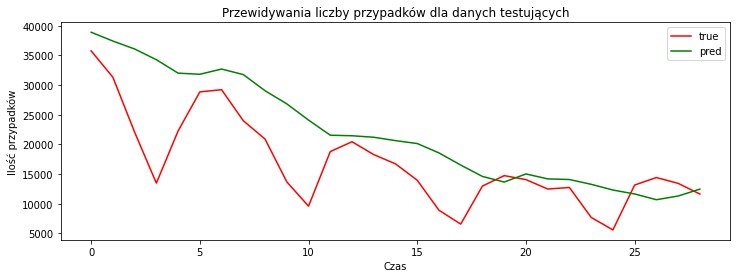

In [178]:
y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących")

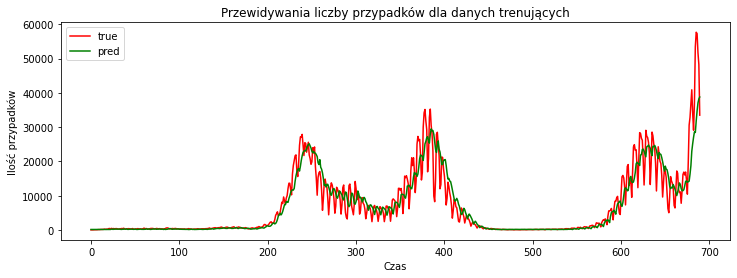

In [179]:
y_preds = prepare_preds(X_train)
draw_predictions(len(y_preds), y_train.reshape(len(y_preds)) * MAX_DATA, y_preds, "trenujących")

In [148]:
y_preds = prepare_preds(X_test)
y = y_test * MAX_DATA
y = np.reshape(y, len(y))
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))

Coefficient of determination: -0.3797543
Index of agreement: 0.7755817
